In [1]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

import librosa
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import pandas as pd
import librosa
import simpleaudio as sa
import math
from IPython import display

print("Finished imports")

C:\Users\1002983\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Finished imports


In [7]:
# Converting into spectrograms
# Spectrograms are stored as spectrograms.tfrecord
nsynth = tf.data.TFRecordDataset("nsynth-test.tfrecord")
i = 1
numTrue = 0
read_features = {
    'note': tf.FixedLenFeature([], dtype=tf.int64),
    'note_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_str': tf.FixedLenFeature([], dtype=tf.string),
    'pitch': tf.FixedLenFeature([], dtype=tf.int64),
    'velocity': tf.FixedLenFeature([], dtype=tf.int64),
    'sample_rate': tf.FixedLenFeature([], dtype=tf.int64),
    'audio': tf.VarLenFeature(dtype=float),
    'instrument_family': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_family_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument_source': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_source_str': tf.FixedLenFeature([], dtype=tf.string)
}
#with tf.python_io.TFRecordWriter('spectrograms.tfrecord') as writer:
if(True):
    acoustic = 0
    electronic = 0
    synthesized = 0
    total = 0
    for b in nsynth:
        data = tf.parse_single_example(serialized=b, features=read_features)
        if(data['instrument_source'].numpy()==0):
            acoustic += 1
            total += 1
        elif(data['instrument_source'].numpy()==1):
            electronic += 1
            total += 1
        elif(data['instrument_source'].numpy()==2):
            synthesized += 1
            total += 1
        print("Acoustic: {}, electronic: {}, synthesized: {}, total: {}".format(acoustic, electronic, synthesized, total), end="\r")
        
        if(data['instrument_source'].numpy()==0):
        #if(True):
            audio = data['audio'].values.numpy()*15000
            audio = np.array(audio)
            spectrogram = librosa.stft(audio, 2048)
            
            magnitudes = np.log(np.abs(spectrogram)).reshape(1025, 126, 1)
            phases = np.angle(spectrogram).reshape(1025, 126, 1)
            minimum = np.amin(magnitudes)
            magnitudes = (magnitudes+minimum)/(np.amax(magnitudes)+minimum)
            phases = (phases + math.pi)/(math.pi*2)
            spec = np.concatenate([magnitudes, phases], 2).flatten().tolist()

            example = tf.train.Example(features=tf.train.Features(feature={
                'note': tf.train.Feature(int64_list=tf.train.Int64List(value=[data['note'].numpy()])),
                'note_str': tf.train.Feature(bytes_list=tf.train.BytesList(value=[data['note_str'].numpy()])),
                'instrument': tf.train.Feature(int64_list=tf.train.Int64List(value=[data['instrument'].numpy()])),
                'instrument_str': tf.train.Feature(bytes_list=tf.train.BytesList(value=[data['instrument_str'].numpy()])),
                'pitch': tf.train.Feature(int64_list=tf.train.Int64List(value=[data['pitch'].numpy()])),
                'velocity': tf.train.Feature(int64_list=tf.train.Int64List(value=[data['velocity'].numpy()])),
                'sample_rate': tf.train.Feature(int64_list=tf.train.Int64List(value=[data['sample_rate'].numpy()])),
                'spectrogram': tf.train.Feature(float_list=tf.train.FloatList(value=spec)),
                'instrument_family': tf.train.Feature(int64_list=tf.train.Int64List(value=[data['instrument_family'].numpy()])),
                'instrument_family_str': tf.train.Feature(bytes_list=tf.train.BytesList(value=[data['instrument_family_str'].numpy()])),
                'instrument_source': tf.train.Feature(int64_list=tf.train.Int64List(value=[data['instrument_source'].numpy()])),
                'instrument_source_str': tf.train.Feature(bytes_list=tf.train.BytesList(value=[data['instrument_source_str'].numpy()]))
            }))
            #writer.write(example.SerializeToString())
            
print("\nDone")

Acoustic: 1689, electronic: 1372, synthesized: 1035, total: 4096
Done


In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))

In [3]:
def playAudio(audio, sr):
    audio = audio.astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, sr)
    play_obj.wait_done()

In [5]:
# to generate gifs
!pip install imageio

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Write the generator and discriminator models

* **Generator** 
  * It is responsible for **creating convincing images that are good enough to fool the discriminator**.
  * It consists of Conv2DTranspose (Upsampling) layers. We start with a fully connected layer and upsample the image 2 times so as to reach the desired image size (mnist image size) which is (28, 28, 1). 
  * We use **leaky relu** activation except for the **last layer** which uses **tanh** activation.
  
* **Discriminator**
  * **The discriminator is responsible for classifying the fake images from the real images.**
  * In other words, the discriminator is given generated images (from the generator) and the real MNIST images. The job of the discriminator is to classify these images into fake (generated) and real (MNIST images).
  * **Basically the generator should be good enough to fool the discriminator that the generated images are real**.

In [6]:
BUFFER_SIZE = 1689
BATCH_SIZE = 3
NUM_CORES = len(os.sched_getaffinity(0))

In [4]:
# Reading spectrograms from TFRecord file
read_features = {
    'note': tf.FixedLenFeature([], dtype=tf.int64),
    'note_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_str': tf.FixedLenFeature([], dtype=tf.string),
    'pitch': tf.FixedLenFeature([], dtype=tf.int64),
    'velocity': tf.FixedLenFeature([], dtype=tf.int64),
    'sample_rate': tf.FixedLenFeature([], dtype=tf.int64),
    'spectrogram': tf.FixedLenFeature([258300], dtype=float),
    'instrument_family': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_family_str': tf.FixedLenFeature([], dtype=tf.string),
    'instrument_source': tf.FixedLenFeature([], dtype=tf.int64),
    'instrument_source_str': tf.FixedLenFeature([], dtype=tf.string)
}

def _map(raw_data):
    return tf.reshape(tf.parse_single_example(serialized=raw_data, features=read_features)['spectrogram'], [1025, 126, 2])

specs = tf.data.TFRecordDataset("spectrograms.tfrecord")
specs = specs.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=BUFFER_SIZE)
specs = specs.map(map_func=_map, num_parallel_calls=NUM_CORES)
specs = specs.batch(batch_size=3)
specs = specs.prefetch(buffer_size=BUFFER_SIZE)

print("\nDone")


Done


In [7]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = tf.keras.layers.Dense(41*7*128, use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        
        self.conv1 = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
    
        self.conv2 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(1, 2), padding='same', use_bias=False)
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
    
        self.conv3 = tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(5, 3), padding='same', use_bias=False)
        self.batchnorm4 = tf.keras.layers.BatchNormalization()
        
        self.conv4 = tf.keras.layers.Conv2DTranspose(2, (5, 5), strides=(5, 3), padding='same', use_bias=False)
        
    def call(self, x, training=True):
        x = self.fc1(x)
        x = self.batchnorm1(x, training=training)
        x = tf.nn.relu(x)
        
        x = tf.reshape(x, shape=(-1, 41, 7, 128))
        
        x = self.conv1(x)
        x = self.batchnorm2(x, training=training)
        x = tf.nn.relu(x)
        
        x = self.conv2(x)
        x = self.batchnorm3(x, training=training)
        x = tf.nn.relu(x)
        
        x = self.conv3(x)
        x = self.batchnorm4(x, training=training)
        x = tf.nn.relu(x)
        
        x = tf.nn.tanh(self.conv4(x))  
        
        return x

In [8]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1)

    def call(self, x, training=True):
        x = tf.nn.leaky_relu(self.conv1(x))
        x = self.dropout(x, training=training)
        x = tf.nn.leaky_relu(self.conv2(x))
        x = self.dropout(x, training=training)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones (since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss
  
* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**
  

* The discriminator and the generator optimizers are different since we will train them separately.

In [12]:
def discriminator_loss(real_output, generated_output):
    return real_output - generated_output

In [13]:
def generator_loss(generated_output):
    return -1*generated_output

## Checkpoints (Object-based saving)

In [15]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

## Training

* We start by iterating over the dataset
* The generator is given **noise as an input** which when passed through the generator model will output a image looking like a handwritten digit
* The discriminator is given the **real MNIST images as well as the generated images (from the generator)**.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables (inputs) and apply those to the optimizer.

## Generate Images

* After training, its time to generate some images!
* We start by creating noise array as an input to the generator
* The generator will then convert the noise into handwritten images.
* Last step is to plot the predictions and **voila!**

In [52]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [63]:
def generate_and_save_images(model, epoch, test_input):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    predictions = sess.run(model(test_input, training=False))

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5, cmap="magma", origin="lower", aspect="auto")
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [54]:
def buildgraph():
    with tf.variable_scope('gen'):
        generator = Generator()
    with tf.variable_scope('disc'):
        discriminator = Discriminator()
    noise = tf.random_normal([BATCH_SIZE, noise_dim])
    
    images = tf.placeholder(tf.float32, shape=[BATCH_SIZE, 1025, 126, 2], name='images')
    
    gen_opt = tf.contrib.layers.optimize_loss(
        tf.reduce_mean(generator_loss(discriminator(generator(noise, training=True), training=True))), 
        None, learning_rate=1e-4, optimizer='Adam', variables=generator.trainable_variables)
    with tf.control_dependencies([gen_opt]):
        gen_opt = tf.tuple([tf.assign(var, tf.clip_by_value(var, -0.01, 0.01)) 
                            for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='gen')])
        
    disc_opt = tf.contrib.layers.optimize_loss(
        tf.reduce_mean(discriminator_loss(
            discriminator(images, training=True), discriminator(generator(noise, training=True), training=True))),
        None, learning_rate=1e-4, optimizer='Adam', variables=discriminator.trainable_variables)
    with tf.control_dependencies([disc_opt]):
        disc_opt = tf.tuple([tf.assign(var, tf.clip_by_value(var, -0.01, 0.01)) 
                             for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='disc')])
    
    return gen_opt, disc_opt, images

In [61]:
def train(dataset, epochs, noise_dim):  
    gen_opt, disc_opt, images = buildgraph()
    sess.run(tf.global_variables_initializer())
    iterator = dataset.make_one_shot_iterator()
    batch = iterator.get_next()
    print('Initialized variables, start training')
    for epoch in range(epochs):
        start = time.time()
        for num in range(math.ceil(BUFFER_SIZE/BATCH_SIZE)):
            if(num % 5 == 4):
                sess.run(gen_opt, feed_dict={images: sess.run(batch)})
            else:
                sess.run(disc_opt, feed_dict={images: sess.run(batch)})
            print("Finished {} out of {}".format(num*3+3, math.ceil(BUFFER_SIZE)), end='\r')
        if epoch % 1 == 0:
            display.clear_output(wait=True)
            generate_and_save_images(generator,
                                   epoch + 1,
                                   random_vector_for_generation)

        # saving (checkpoint) the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                          time.time()-start))
  # generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

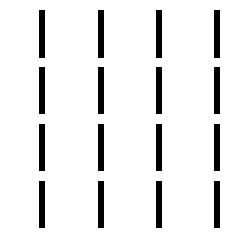

Time taken for epoch 39 is 1354.5719738006592 sec


KeyboardInterrupt: 

In [62]:
train(specs, EPOCHS, noise_dim)

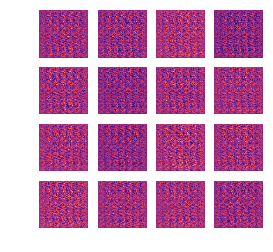

In [65]:
generate_and_save_images(generator, 0, random_vector_for_generation)

## Restore the latest checkpoint

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

In [ ]:
# def display_image(epoch_no):
#     return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
# display_image(EPOCHS)

## Generate a GIF of all the saved images.

<!-- TODO(markdaoust): Remove the hack when Ipython version is updated -->


In [ ]:
"""
with imageio.get_writer('dcgan.gif', mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp dcgan.gif dcgan.gif.png')
"""

In [ ]:
# display.Image(filename="dcgan.gif.png")

To downlod the animation from Colab uncomment the code below:

In [ ]:
#from google.colab import files
#files.download('dcgan.gif')